# Проект "Определение стоимости автомобилей"

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Этапы проекта:
1. Подготовка данных.
    - Ознакомиться с имеющимися данными.
    - Изменить название и тип столбцов где необходимо.
    - Проверить наличие явных и неявных дубликатов. 
    - Удалить или заполнить пропуски.
    - Исследовать данные на предмет аномалий и выбросов. Обработать их, где необходимо.
    - Исследовать характер распределения данных;
    - Удалить данные, не имеющие практической пользы для построения модели;
    - Подготовить данные для построения моделей (масштабирование, кодирование, если применимо);
2. Обучение моделей:
    - Построить несколько моделей, включая как минимум одну LightGBM и как минимум одну не-бустинг модель.
    - В данном проекте будем использовать дерево решений, случайный лес, LightGBM и CatBoost.
    - Оценка качества моделей будет производиться с помощью метрики RMSE.
3. Анализ работы моделей:
    - Построение различных типов моделей и подбор гиперпараметров;
    - Оценка метрик моделей. Выбор лучшей;
    - Проверка выбранной модели с помощью тестовой выборки;

## Подготовка данных

В данном этапе работы нам необходимо:
- Ознакомиться с имеющимися данными.
- Изменить название и тип столбцов где необходимо.
- Проверить наличие явных и неявных дубликатов. 
- Удалить или заполнить пропуски.
- Удалить данные, не имеющие практической пользы для построения модели.
- Исследовать данные на предмет аномалий и выбросов. Обработать их, где необходимо.
- Исследовать характер распределения данных.
- Исследовать мультиколлинеарность.
- Подготовить данные для построения моделей (масштабирование, кодирование, если применимо).
- Разделить датасет на обучающую и тестовую выборки в соотношении 3:1.

In [1]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pydantic-settings

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats as st
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             accuracy_score, 
                             f1_score, roc_curve,
                             roc_auc_score,
                             make_scorer)
from sklearn.utils import shuffle
from tqdm import tqdm

import sweetviz as sv 
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor

In [6]:
data = pd.read_csv('autos.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Итак мы имеем датасет с 16 столбцами и 354369 строками, часть из которых содержит пропуски в различных столбцах.  

Начнём выполнение этапов по порядку.

### Изменение названия и типов данных столбцов

In [7]:
# приведем названия столбцов в соответствие snake_case
data = data.rename(columns={
    'DateCrawled': 'profile_downloaded_date',
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox_type',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'mileage',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'was_repaired',
    'DateCreated': 'profile_creation_date',
    'NumberOfPictures': 'number_of_pictures',
    'PostalCode': 'postcode',
    'LastSeen': 'user_last_online'
})

In [8]:
# изменим тип данных столбцов
data['profile_downloaded_date'] = pd.to_datetime(data['profile_downloaded_date'])
data['profile_creation_date'] = pd.to_datetime(data['profile_creation_date'])

### Работа с дубликатами

In [9]:
# теперь оценим количество явных и неявных дубликатов
data.duplicated().sum()

4

In [10]:
# и удалим их
data = data.drop_duplicates().reset_index(drop=True)

In [11]:
# оценим неявные дубликаты 
object_columns = ['vehicle_type', 'gearbox_type', 'model', 'fuel_type', 'brand', 'was_repaired']
for i in object_columns:
    data[i] = data[i].str.lower()
    

In [12]:
data[['vehicle_type',
     'registration_year',
     'gearbox_type',
     'power',
     'model',
     'mileage',
     'registration_month',
     'fuel_type',
     'brand',
     'was_repaired',
     'profile_creation_date',
     'number_of_pictures',
     'postcode'
    ]].duplicated().sum()

11876

Количество неявных дубликатов составляет менее 4%. Можем удалить эти данные.

In [13]:
data.drop_duplicates(subset=[
    'vehicle_type',
    'registration_year',
    'gearbox_type',
    'power',
    'model',
    'mileage',
    'registration_month',
    'fuel_type',
    'brand',
    'was_repaired',
    'profile_creation_date',
    'number_of_pictures',
    'postcode'
], inplace=True)

### Обработка пропусков

In [14]:
data_na_1 = data.isna().sum()
display(data_na_1[data_na_1 > 0])
data_na_2 = data.isna().mean().round(3)
data_na_2[data_na_2 > 0]

vehicle_type    36869
gearbox_type    19397
model           19381
fuel_type       32380
was_repaired    69733
dtype: int64

vehicle_type    0.108
gearbox_type    0.057
model           0.057
fuel_type       0.095
was_repaired    0.204
dtype: float64

In [15]:
data.isna().any(axis=1).sum()

106568

Видим, что у нас есть 5 столбцов, в которых имеются пропуски, и которые составляют от 6 до 20 процентов столбца.  
Если удалить все строки, в которых содержится хотя бы один пропуск, то получится довольно ощутимое количество - почти треть датасета, поэтому попробуем частично их заполнить. 

In [16]:
for i in data_na_2[data_na_2 > 0].index:
    print(i, data[i].unique(), '\n')


vehicle_type [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

gearbox_type ['manual' 'auto' nan] 

model ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spide

Как мы видим, в столбцах vehicle_type, model, fuel_type уже присутвует категория "other". Поэтому все пропуски в этих столбцах заменим на эту категорию.

Столбец was_repaired содержит слишком много пропусков, чтобы их просто удалить, поэтому сделаем предположение, что, если данные не указаны, значит автомобиль не был в ремонте (в конце концов, как иначе может быть в компании "Не бит, не крашен").

Столбец gearbox_type мы никак не можем заполнить случайным образом, так как одинаковые модели автомобилей могут быть как с автоматической, так и с ручной коробкой, но пропусков в этом столбце не так много (~6%), поэтому удалим строчки с пропусками.

In [17]:
data['vehicle_type'].fillna('other', inplace=True)
data['model'].fillna('other', inplace=True)
data['fuel_type'].fillna('other', inplace=True)
data['was_repaired'].fillna('no', inplace=True)

data = data.dropna(subset=['gearbox_type'])
data.reset_index(inplace=True, drop=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323092 entries, 0 to 323091
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   profile_downloaded_date  323092 non-null  datetime64[ns]
 1   price                    323092 non-null  int64         
 2   vehicle_type             323092 non-null  object        
 3   registration_year        323092 non-null  int64         
 4   gearbox_type             323092 non-null  object        
 5   power                    323092 non-null  int64         
 6   model                    323092 non-null  object        
 7   mileage                  323092 non-null  int64         
 8   registration_month       323092 non-null  int64         
 9   fuel_type                323092 non-null  object        
 10  brand                    323092 non-null  object        
 11  was_repaired             323092 non-null  object        
 12  profile_creation

### Исследование распределения данных и наличия выбросов / аномалий

Прежде чем приступить к исследованию данных, удалим столбцы, которые никак не влияют на итоговую стоимость автомобиля, а именно:
- profile_downloaded_date - дата скачивания анкеты из базы.
- profile_creation_date - дата создания анкеты.
- user_last_online - дата последней активности пользователя.
- registration_month - месяц регистрации автомобиля (так как у нас есть данные о годе регистрации).
- number_of_pictures - количество фотографий автомобиля, так как столбец полностью состоит из нулей.

In [18]:
data_dropped = data.drop(['profile_downloaded_date', 'profile_creation_date', 'user_last_online', 'registration_month', 'number_of_pictures'], axis=1)

In [19]:
# исследуем данные с помощью sweetviz
# sv_report = sv.analyze(data_dropped)

In [20]:
# sv_report.show_html('data_analysis.html')

В большинстве столбцов данные распределены адекватно, без каких-либо выраженных выбросов или аномалий, кроме столбцов **registration_year и power**. Исследуем эти столбцы подробнее.

In [21]:
data_dropped['registration_year'].describe()

count    323092.000000
mean       2003.338473
std          30.631231
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9000.000000
Name: registration_year, dtype: float64

<AxesSubplot:>

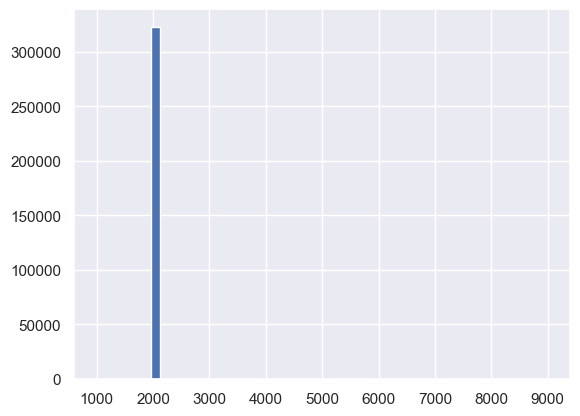

In [22]:
sns.set_theme(style='darkgrid')
data_dropped['registration_year'].hist(bins=50)


Как видно из данных выше, в столбце с годом регистрации есть явные аномалии, такие как год 9000 и 1000.

In [23]:
data_dropped['power'].describe()

count    323092.000000
mean        114.273377
std         192.585707
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

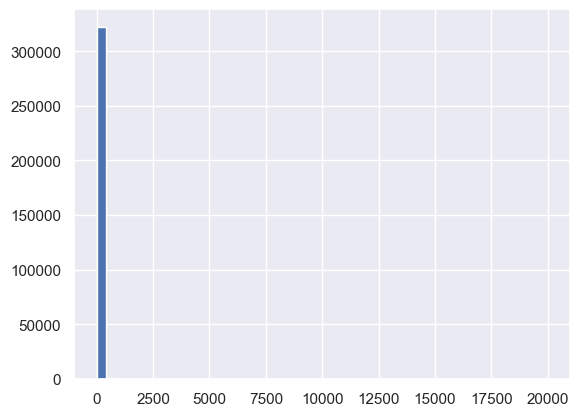

In [24]:
data_dropped['power'].hist(bins=50)
None

In [25]:
# создадим функцию для отсечения данных сверх +- 3 стандартных отклонения
def std3_cut(data):
    data_columns = list(data.columns)
    
    for i in data_columns:
        mean = data[i].mean()
        std = data[i].std()
        data[i] = data[i][(data[i] > (mean - std * 3)) & (data[i] < (mean + std * 3))]
    return data

In [26]:
data_dropped[['registration_year', 'power', 'price']] = std3_cut(data_dropped[['registration_year', 'power', 'price']])

C:\Users\user\AppData\Local\Temp\ipykernel_23088\3576817451.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = data[i][(data[i] > (mean - std * 3)) & (data[i] < (mean + std * 3))]
C:\Users\user\AppData\Local\Temp\ipykernel_23088\3576817451.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i] = data[i][(data[i] > (mean - std * 3)) & (data[i] < (mean + std * 3))]
C:\Users\user\AppData\Local\Temp\ipykernel_23088\3576817451.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy o

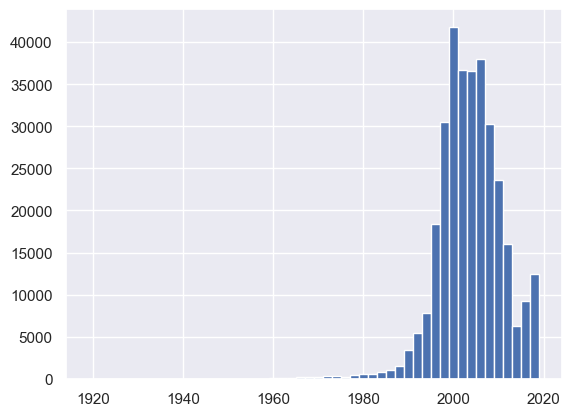

In [27]:
data_dropped['registration_year'].hist(bins=50)
None

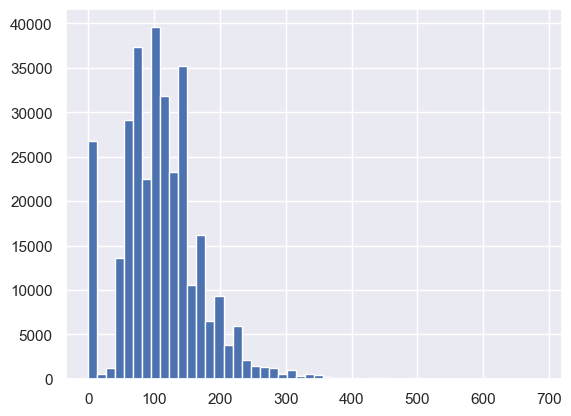

In [28]:
data_dropped['power'].hist(bins=50)
None

Заметим, что в столбце с мощностью двигателя существуют строки с мощностью, равной нулю или околонулевым значениям, что явно является аномалией. Оценим количество таких строк.

27731


<AxesSubplot:>

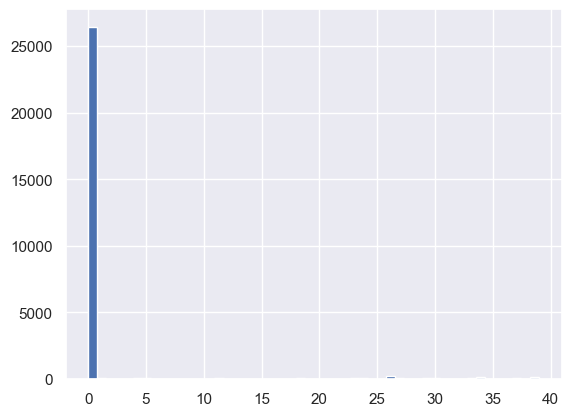

In [29]:
power_data = data_dropped.loc[(data_dropped['power'] < 40), 'power']
print(power_data.count())
power_data.hist(bins=50)

In [30]:
# удалим строки, в которых указанная мощность меньше 40
data_dropped = data_dropped[(data_dropped['power'] > 40)]
data_dropped.reset_index(drop=True, inplace=True)

С выбросами и аномалиями разобрались. 



In [31]:
# заполним появившееся небольшое количество пропусков медианным значением по соответствующему столбцу
data_dropped['registration_year'].fillna(data_dropped['registration_year'].median(), inplace=True)


In [32]:
# удалим из датасета строки, год регистрации которых больше чем год скачивания анкет (>2016)
data_dropped[data_dropped['registration_year'] > 2016].shape[0]

9786

In [33]:
data_dropped = data_dropped[(data_dropped['registration_year'] <= 2016)]
data_dropped.reset_index(drop=True, inplace=True)

In [34]:
data_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284942 entries, 0 to 284941
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              280556 non-null  float64
 1   vehicle_type       284942 non-null  object 
 2   registration_year  284942 non-null  float64
 3   gearbox_type       284942 non-null  object 
 4   power              284942 non-null  float64
 5   model              284942 non-null  object 
 6   mileage            284942 non-null  int64  
 7   fuel_type          284942 non-null  object 
 8   brand              284942 non-null  object 
 9   was_repaired       284942 non-null  object 
 10  postcode           284942 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 23.9+ MB


In [35]:
data_dropped = data_dropped[(data_dropped['price'] > 100)]
data_dropped.reset_index(drop=True, inplace=True)

In [36]:
data_dropped[data_dropped['price'] < 100].sort_values(by='price')

,price,vehicle_type,registration_year,gearbox_type,power,model,mileage,fuel_type,brand,was_repaired,postcode


In [37]:
data['price'].describe()

count    323092.000000
mean       4525.800948
std        4544.356316
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

<AxesSubplot:>

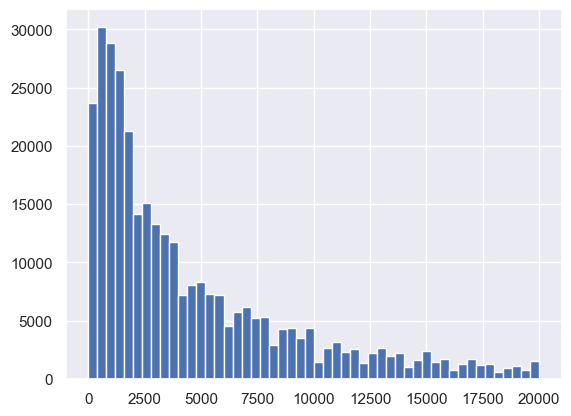

In [38]:
data['price'].hist(bins=50)

### Исследование мультиколлинеарности и подготовка данных

In [39]:
data_dropped.corr(method='spearman')

,price,registration_year,power,mileage,postcode
price,1.000000,0.666663,0.512994,-0.359766,0.063542
registration_year,0.666663,1.000000,0.167186,-0.382763,0.037530
power,0.512994,0.167186,1.000000,0.135514,0.062071
mileage,-0.359766,-0.382763,0.135514,1.000000,-0.017991
postcode,0.063542,0.037530,0.062071,-0.017991,1.000000


Как мы видим, признаки не имеют сильной коллинеарности между собой, поэтому оставляем их как есть.

Помимо этого нам нужно модифицировать имеющиеся категориальные текстовые признаки, чтобы их могли обрабатывать базовые модели, например, модель случайного леса.  
Для этого будем использовать Ordinal encoding, ввиду большого количества различных категорий.

In [40]:
object_columns = [
    'vehicle_type',
    'gearbox_type',
    'model',
    'fuel_type',
    'brand',
    'was_repaired'
]


In [41]:
# теперь разделим наш датасет на обучающую и тестовую выборки в соотношении 3:1
features = data_dropped.drop('price', axis=1)
target = data_dropped['price']

In [42]:
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=123)
display(features_train.shape[0], features_test.shape[0], target_train.shape[0], target_test.shape[0])

204918

68307

204918

68307

In [43]:
# encoder

object_columns = [
    'vehicle_type',
    'gearbox_type',
    'model',
    'fuel_type',
    'brand',
    'was_repaired'
]

features_train_encoded = features_train.copy()
features_test_encoded = features_test.copy()

encoder = OrdinalEncoder()

encoder.fit(features_train[object_columns])

features_train_encoded[object_columns] = pd.DataFrame(
    encoder.transform(features_train[object_columns]
),
    index=features_train.index,
    columns=object_columns)

features_test_encoded[object_columns] = pd.DataFrame(
    encoder.transform(features_test[object_columns]
                     ),
    index=features_test.index,
    columns=object_columns)


In [44]:
features_test_encoded.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68307 entries, 14948 to 43251
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   vehicle_type       68307 non-null  float64
 1   registration_year  68307 non-null  float64
 2   gearbox_type       68307 non-null  float64
 3   power              68307 non-null  float64
 4   model              68307 non-null  float64
 5   mileage            68307 non-null  int64  
 6   fuel_type          68307 non-null  float64
 7   brand              68307 non-null  float64
 8   was_repaired       68307 non-null  float64
 9   postcode           68307 non-null  int64  
dtypes: float64(8), int64(2)
memory usage: 5.7 MB


Итак, в течение первого этапа проекта мы выполнили следующие действия:
- Ознакомились с имеющимися данными.
- Скорректировали название столбцов на snake_case и изменили тип данных на datetime для соответствующих столбцов.
- Проверили наличие явных и неявных дубликатов и удалили их из датасета. 
- Оценили количество пропусков в различных столбцах. Часть пропусков заполнили, изменив категорию на 'other', столбец с фактом ремонта заполнили, исходя из предположения, что отсутствие данных говорит об отсутствии ремонта. Оставшуюся незначительную часть пропусков удалили.
- Также удалили данные, не имеющие практической пользы для построения модели, в частности:
    - profile_downloaded_date - дата скачивания анкеты из базы.
    - profile_creation_date - дата создания анкеты.
    - user_last_online - дата последней активности пользователя.
    - registration_month - месяц регистрации автомобиля (так как у нас есть данные о годе регистрации).
    - number_of_pictures - количество фотографий автомобиля, так как столбец полностью состоит из нулей.
- Исследовали данные на предмет аномалий и выбросов. Обработали их в столбцах registration_year и power путем отсечения данных, выходящих за +- 3 стандартных отклонения от среднего выборки. Также для столбца power удалили строки, в которых содержались нереалистичные данные о мощности двигателя (около нулевые значения).
- Исследовали мультиколлинеарность. Наивысший обнаруженный уровень коллинеарности - значимый (~0.5). Корректировок не требовалось.
- Подготовить данные для построения моделей - использовали Ordinal encoding для кодирования категориальных признаков, таких как:
    - Тип автомобиля - vehicle_type.
    - Тип трансмиссии - gearbox_type.
    - Модель - model.
    - Тип топлива - fuel_type.
    - Бренд - brand.
- Разделили выборки на обучающую и тестовую в соотношении 3:1.

Итого данные подготовлены для построения и обучения моделей. Можем переходить ко второму этапу проекта.

## Обучение моделей

В данном этапе проекта нам предстоит:
- Построить несколько моделей, включая как минимум одну LightGBM и как минимум одну не-бустинг модель.
- В данном проекте будем использовать дерево решений, случайный лес, LightGBM и CatBoost.
- Оценка качества моделей будет производиться с помощью метрики RMSE.

Начнем построение моделей по порядку.

In [46]:
# начнем с модели дерева решений

decision_tree = DecisionTreeRegressor(random_state=12345)

tree_parameters_grid = {
   'max_depth' : range(1, 15)
}

# mse = make_scorer(mean_squared_error, greater_is_better=False)

tree_grid_cv_1 = GridSearchCV(
    decision_tree,
    tree_parameters_grid,
    cv=3,
    scoring = 'neg_mean_squared_error',
    verbose=3
)
tree_grid_cv_1.fit(features_train_encoded, target_train)
print(f'Наилучшее значение параметра max_depth: {tree_grid_cv_1.best_params_}') 
print(f'Наилучший показатель RMSE: {(tree_grid_cv_1.best_score_ * (-1))**0.5}')


Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3] END ...............max_depth=1;, score=-11444390.254 total time=   0.0s
[CV 2/3] END ...............max_depth=1;, score=-11527426.195 total time=   0.0s
[CV 3/3] END ...............max_depth=1;, score=-11505278.903 total time=   0.0s
[CV 1/3] END ................max_depth=2;, score=-8830299.792 total time=   0.0s
[CV 2/3] END ................max_depth=2;, score=-8839997.610 total time=   0.0s
[CV 3/3] END ................max_depth=2;, score=-8839205.942 total time=   0.0s
[CV 1/3] END ................max_depth=3;, score=-7435499.491 total time=   0.0s
[CV 2/3] END ................max_depth=3;, score=-7510155.784 total time=   0.0s
[CV 3/3] END ................max_depth=3;, score=-7429166.570 total time=   0.0s
[CV 1/3] END ................max_depth=4;, score=-5952501.681 total time=   0.0s
[CV 2/3] END ................max_depth=4;, score=-6075875.510 total time=   0.0s
[CV 3/3] END ................max_depth=4;, score

Итак для модели дерева решений мы получили оптимальное значение параметра max_depth=12 и RMSE ~ 2053.

Переходим к модели случайного леса.

In [48]:
# теперь перейдем к модели случайного леса

random_forest = RandomForestRegressor(random_state=12345)

forest_parameters_grid = {
    'max_depth' : range(10, 20, 3),
    'n_estimators' : list(map(int, np.linspace(100, 160, 4)))
}

forest_grid_cv = GridSearchCV(
    random_forest,
    forest_parameters_grid,
    cv=3,
    scoring = 'neg_mean_squared_error',
    verbose=3
    #n_jobs=-1
)
forest_grid_cv.fit(features_train_encoded, target_train)
print(f'Наилучшее значение параметра max_depth: {forest_grid_cv.best_params_}') 
print(f'Наилучший показатель RMSE: {(forest_grid_cv.best_score_ * (-1))**0.5}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END max_depth=10, n_estimators=100;, score=-3048392.551 total time=  18.5s
[CV 2/3] END max_depth=10, n_estimators=100;, score=-3149945.849 total time=  18.5s
[CV 3/3] END max_depth=10, n_estimators=100;, score=-3046425.444 total time=  18.6s
[CV 1/3] END max_depth=10, n_estimators=120;, score=-3045468.658 total time=  22.7s
[CV 2/3] END max_depth=10, n_estimators=120;, score=-3148693.539 total time=  22.4s
[CV 3/3] END max_depth=10, n_estimators=120;, score=-3042743.604 total time=  22.4s
[CV 1/3] END max_depth=10, n_estimators=140;, score=-3045168.117 total time=  26.1s
[CV 2/3] END max_depth=10, n_estimators=140;, score=-3151003.451 total time=  26.0s
[CV 3/3] END max_depth=10, n_estimators=140;, score=-3041897.070 total time=  26.1s
[CV 1/3] END max_depth=10, n_estimators=160;, score=-3044694.787 total time=  29.8s
[CV 2/3] END max_depth=10, n_estimators=160;, score=-3151643.713 total time=  29.8s
[CV 3/3] END ma

Для модели случайного леса мы получили:
- max_depth=20.
- n_estimators=160.
- RMSE ~ 1740, что укладывается в наш целевой показатель по эффективности модели (<2500)


In [50]:
# Теперь переходим к градиентному бустингу с помощью LGBM

lgbm_model = LGBMRegressor(random_state=12345)

lgbm_parameters_grid = {
    'max_depth' : range(10, 20, 3),
    'n_estimators' : list(map(int, np.linspace(100, 200, 3)))
    #'learning_rate': [0.1, 1.0]
}

lgbm_grid_cv = GridSearchCV(
    lgbm_model,
    lgbm_parameters_grid,
    cv=3,
    scoring = 'neg_mean_squared_error',
    verbose=3
    #n_jobs=-1
)
lgbm_grid_cv.fit(features_train_encoded, target_train)
print(f'Наилучшие значения параметров: {lgbm_grid_cv.best_params_}') 
print(f'Наилучший показатель RMSE: {(lgbm_grid_cv.best_score_ * (-1))**0.5}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 136612, number of used features: 10
[LightGBM] [Info] Start training from score 4686.064431
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] END max_depth=10, n_estimators=100;, score=-2512870.214 total time=   0.3s
[LightGBM] [Warning] Accuracy may be bad since you didn'

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 1/3] END max_depth=13, n_estimators=100;, score=-2505342.567 total time=   0.3s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 136612, number of used features: 10
[LightGBM] [Info] Start training from score 4681.842122
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 2/3] END max_depth=16, n_estimators=100;, score=-2575874.091 total time=   0.3s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 869
[LightGBM] [Info] Number of data points in the train set: 136612, number of used features: 10
[LightGBM] [Info] Start training from score 4674.889278
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV 3/3] END max_depth=19, n_estimators=100;, score=-2517791.077 total time=   0.3s
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 877
[LightGBM] [Info] Number of data points in the train set: 136612, number of used features: 10
[LightGBM] [Info] Start training from score 4686.064431
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num

Итак для модели LGBM мы получили:
- max_depth=13.
- n_estimators=200.
- learning_rate=0.1
- RMSE ~ 1542, что укладывается в наш целевой показатель по эффективности модели (<2500)

In [51]:
# перейдем к последней модели - CatBoost
catboost_model = CatBoostRegressor(random_state=12345, verbose=False)

catboost_parameters_grid = {
    'max_depth' : range(10, 20, 3),
    'n_estimators' : list(map(int, np.linspace(100, 200, 3)))
}

catboost_grid_cv = GridSearchCV(
    catboost_model,
    catboost_parameters_grid,
    cv=3,
    scoring = 'neg_mean_squared_error',
    verbose=3
    #n_jobs=-1
)
catboost_grid_cv.fit(features_train_encoded, target_train)
print(f'Наилучшие значения параметров: {catboost_grid_cv.best_params_}') 
print(f'Наилучший показатель RMSE: {(catboost_grid_cv.best_score_ * (-1))**0.5}')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END max_depth=10, n_estimators=100;, score=-2298389.206 total time=   1.9s
[CV 2/3] END max_depth=10, n_estimators=100;, score=-2354822.155 total time=   1.7s
[CV 3/3] END max_depth=10, n_estimators=100;, score=-2280874.307 total time=   1.7s
[CV 1/3] END max_depth=10, n_estimators=150;, score=-2256162.593 total time=   2.5s
[CV 2/3] END max_depth=10, n_estimators=150;, score=-2318964.740 total time=   2.5s
[CV 3/3] END max_depth=10, n_estimators=150;, score=-2244335.239 total time=   2.6s
[CV 1/3] END max_depth=10, n_estimators=200;, score=-2232624.904 total time=   3.5s
[CV 2/3] END max_depth=10, n_estimators=200;, score=-2294872.674 total time=   3.4s
[CV 3/3] END max_depth=10, n_estimators=200;, score=-2218622.517 total time=   3.5s
[CV 1/3] END max_depth=13, n_estimators=100;, score=-2309845.659 total time=   9.2s
[CV 2/3] END max_depth=13, n_estimators=100;, score=-2363526.315 total time=   8.7s
[CV 3/3] END ma

E:\Anaconda\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
9 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "E:\Anaconda\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Anaconda\envs\practicum\lib\site-packages\catboost\core.py", line 5807, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "E:\Anaconda\envs\practicum\lib\site-packages\catboost\core.py", line 2381, in _

Наилучшие значения параметров: {'max_depth': 13, 'n_estimators': 200}
Наилучший показатель RMSE: 1497.405200024209


Показатели модели CatBoost:
- max_depth=13.
- n_estimators=200.
- RMSE ~ 1497, что укладывается в наш целевой показатель по эффективности модели (<2500)

Итак, в течение данного этапа мы обучили четыре типа модели: дерево решений, случайный лес, LGBM и Catboost.  
Все модели показали свою эффективность и прошли заданный целевой порог метрики RMSE (<2500).  
В следующем этапе нам предстоит сравнить полученные модели между собой и определить, какая из них наилучшим образом соответствует запросу клиента.

## Анализ моделей

В данном этапе нам предстоит проанализировать построенные модели по всем критериям заказчика, а именно:
- качество предсказания;
- скорость предсказания;
- время обучения.

На основании этих данных будет выбрана наиболее оптимальная модель.

In [52]:
%%time 
# оценка скорости работы моделей
decision_tree = DecisionTreeRegressor(max_depth=12, random_state=12345)
decision_tree.fit(features_train_encoded, target_train)

CPU times: total: 484 ms
Wall time: 484 ms


DecisionTreeRegressor(max_depth=12, random_state=12345)

In [53]:
%%time
decision_tree_pred = decision_tree.predict(features_train_encoded)

CPU times: total: 15.6 ms
Wall time: 28.2 ms


In [54]:
%%time
random_forest = RandomForestRegressor(max_depth=20, n_estimators=160, random_state=12345)
random_forest.fit(features_train_encoded, target_train)

CPU times: total: 1min 24s
Wall time: 1min 24s


RandomForestRegressor(max_depth=20, n_estimators=160, random_state=12345)

In [55]:
%%time
random_forest_pred = random_forest.predict(features_train_encoded)

CPU times: total: 6.55 s
Wall time: 6.58 s


In [56]:
%%time
lgbm_model = LGBMRegressor(max_depth=12, n_estimators=200, learning_rate=0.1, random_state=12345)
lgbm_model.fit(features_train_encoded, target_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 204918, number of used features: 10
[LightGBM] [Info] Start training from score 4680.931944
CPU times: total: 3.88 s
Wall time: 742 ms


LGBMRegressor(max_depth=12, n_estimators=200, random_state=12345)

In [57]:
%%time
lgbm_model_pred = lgbm_model.predict(features_train_encoded)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
CPU times: total: 2.19 s
Wall time: 278 ms


In [58]:
%%time
catboost_model = CatBoostRegressor(max_depth=12, n_estimators=200, random_state=12345, verbose=False)
catboost_model.fit(features_train_encoded, target_train)

CPU times: total: 49.7 s
Wall time: 10.5 s


In [59]:
%%time
catboost_model_pred = catboost_model.predict(features_train_encoded)

CPU times: total: 500 ms
Wall time: 65 ms


Дерево решений:
- Время обучения - 620мс.
- Скорость предсказания - 32.6мс.
- RMSE ~ 2053.
Случайный лес:
- Время обучения - 1мин 34с.
- Скорость предсказания - 8.8мс.
- RMSE ~ 1740.
LGBM:
- Время обучения - 11мин 35с.
- Скорость предсказания - 2.7с.
- RMSE ~ 1753
CatBoost:
- Время обучения - 18с.
- Скорость предсказания - 209мс.
- RMSE ~ 1710

Итого лучшая модель по совокупности показателей - CatBoost.  
Проверим её на тестовой выборке.

In [60]:
catboost_model = CatBoostRegressor(max_depth=12, n_estimators=200, random_state=12345, verbose=False)

catboost_model.fit(features_train_encoded, target_train)
catboost_model_test_pred = catboost_model.predict(features_test_encoded)

rmse = mean_squared_error(target_test, catboost_model_test_pred, squared=False)
rmse

E:\Anaconda\envs\practicum\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


1468.574574949515

## Общий вывод

В данном проекте нам необходимо было построить модель предсказания стоимости автомобиля для компании "Не бит, не крашен" на основании имеющихся технических данных.

Основными критериями заказчика являлись:
- качество предсказания;
- скорость предсказания;
- время обучения.

**1 этап работы**

- Ознакомились с имеющимися данными.
- Скорректировали название столбцов на snake_case и изменили тип данных на datetime для соответствующих столбцов.
- Проверили наличие явных и неявных дубликатов и удалили их из датасета. 
- Оценили количество пропусков в различных столбцах. Часть пропусков заполнили, изменив категорию на 'other', столбец с фактом ремонта заполнили, исходя из предположения, что отсутствие данных говорит об отсутствии ремонта. Оставшуюся незначительную часть пропусков удалили.
- Также удалили данные, не имеющие практической пользы для построения модели, в частности:
    - profile_downloaded_date - дата скачивания анкеты из базы.
    - profile_creation_date - дата создания анкеты.
    - user_last_online - дата последней активности пользователя.
    - registration_month - месяц регистрации автомобиля (так как у нас есть данные о годе регистрации).
    - number_of_pictures - количество фотографий автомобиля, так как столбец полностью состоит из нулей.
- Исследовали данные на предмет аномалий и выбросов. Обработали их в столбцах registration_year и power путем отсечения данных, выходящих за +- 3 стандартных отклонения от среднего выборки. Также для столбца power удалили строки, в которых содержались нереалистичные данные о мощности двигателя (около нулевые значения).
- Исследовали мультиколлинеарность. Наивысший обнаруженный уровень коллинеарности - значимый (~0.5). Корректировок не требовалось.
- Подготовить данные для построения моделей - использовали Ordinal encoding для кодирования категориальных признаков, таких как:
    - Тип автомобиля - vehicle_type.
    - Тип трансмиссии - gearbox_type.
    - Модель - model.
    - Тип топлива - fuel_type.
    - Бренд - brand.
- Разделили выборки на обучающую и тестовую в соотношении 3:1.

**2 этап работы**

Для тестирования были выбраны 4 типа моделей (дерево решений, случайный лес, LGBM и CatBoost). Для каждой модели подобраны гиперпараметры и проведена кросс-валидация.
- Дерево решений:
    - max_depth=12 и RMSE ~ 2053.
- Случайный лес:
    - max_depth=20.
    - n_estimators=160.
    - RMSE ~ 1740
- LGBM:
    - max_depth=12.
    - n_estimators=200.
    - learning_rate=0.1
    - RMSE ~ 1753
- CatBoost:
    - max_depth=12.
    - n_estimators=200.
    - RMSE ~ 1710

**3 этап работы**

Были проанализированы качество предсказания, скорость обучения и время обучения выбранных моделей.
- Дерево решений:
    - Время обучения - 685мс.
    - Скорость предсказания - 11.6мс.
    - Качество предсказания (RMSE) - 2032.11.
- Случайный лес:
    - Время обучения - 1мин.43сек.
    - Скорость предсказания - 3.49сек.
    - Качество предсказания (RMSE) - 1723.26
- LGBM:
    - Время обучения - 1мин.1с.
    - Скорость предсказания - 945мс.
    - Качество предсказания (RMSE) - 1779.30.
- CatBoost:
    - Время обучения - 26.6с.
    - Скорость предсказания - 72.9мс.
    - Качество предсказания (RMSE) - 1750.
    
Итого по результатам проекта мы выяснили, что по совокупности показателей и скорости работы наиболее оптимальным выбором в данном случае является CatBoost. Эту модель можно предлагать заказчику.  
Показатель этой модели на тестовой выборке:
- RMSE ~1468

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей